# CH-04 讓 AI 計算技術指標及資料視覺化

## 4-1 技術指標公式太複雜？讓 AI 自動化計算

### 1️⃣ 安裝及匯入套件

In [1]:
!pip install openai
!pip install yfinance -U

In [2]:
from  openai import OpenAI, OpenAIError # 串接 OpenAI API
import yfinance as yf
import pandas as pd # 資料處理套件
import datetime as dt # 時間套件

### 2️⃣ 取得股票資料

In [3]:
# 輸入股票代號
stock_id = "2330.tw"
# 抓取半年資料
end = dt.date.today() # 資料結束時間
start = end - dt.timedelta(days=180) # 資料開始時間

#df = yf.download(stock_id, start=start, end=end).reset_index()
df = yf.Ticker(stock_id).history(start=start, end=end)
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-10-13 00:00:00+08:00,1390.0,1420.0,1390.0,1415.0,53850992,0.0,0.0
2025-10-14 00:00:00+08:00,1455.0,1460.0,1420.0,1425.0,39889256,0.0,0.0
2025-10-15 00:00:00+08:00,1435.0,1465.0,1425.0,1465.0,41056405,0.0,0.0
2025-10-16 00:00:00+08:00,1465.0,1495.0,1465.0,1485.0,37737678,0.0,0.0
2025-10-17 00:00:00+08:00,1455.0,1465.0,1450.0,1450.0,38077331,0.0,0.0


### 3️⃣ 輸入 GEMINI API KEY

In [4]:
from google.colab import userdata

client = OpenAI(
    api_key=userdata.get('GEMINI_API_KEY'),
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

### 4️⃣ 創建 Gemini 2.5 Flash 模型函式

In [5]:
def get_reply(messages):
  try:
    response = client.chat.completions.create(model="gemini-2.5-flash", messages=messages)
    reply = response.choices[0].message.content
  except OpenAIError as err:
    reply = f"發生 {err.type} 錯誤\n{err.message}"
  return reply

# 設定 AI 角色, 使其依據使用者需求進行 df 處理
def ai_helper(df, user_msg):

  msg = [{
    "role":
    "system",
    "content":
    f"As a professional code generation robot, \
      I require your assistance in generating Python code \
      based on specific user requirements. To proceed, \
      I will provide you with a dataframe (df) that follows the \
      format {df.columns}. Your task is to carefully analyze the \
      user's requirements and generate the Python code \
      accordingly.Please note that your response should solely \
      consist of the code itself, \
      and no additional information should be included."
  }, {
    "role":
    "user",
    "content":
    f"The user requirement:{user_msg} \n\
       Your task is to develop a Python function named \
      'calculate(df)'. This function should accept a dataframe as \
      its parameter. Ensure that you only utilize the columns \
      present in the dataset, specifically {df.columns}. \
      After processing, the function should return the processed \
      dataframe. Your response should strictly contain the Python \
      code for the 'calculate(df)' function \
      and exclude any unrelated content."
  }]

  reply_data = get_reply(msg)
  cleaned_code = reply_data.replace("```", "")
  cleaned_code = cleaned_code.replace("python", "")

  return cleaned_code

### 讓 AI 自動生成技術指標程式碼

### 5️⃣ 計算移動平均線

In [6]:
code_str = ai_helper(df, "計算8日MA與13日MA ")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df):
    """
    Calculates the 8-day Moving Average (MA_8) and 13-day Moving Average (MA_13)
    based on the 'Close' price of the input DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame with at least a 'Close' column.

    Returns:
    pd.DataFrame: The DataFrame with 'MA_8' and 'MA_13' columns added.
    """
    df['MA_8'] = df['Close'].rolling(window=8).mean()
    df['MA_13'] = df['Close'].rolling(window=13).mean()
    return df



,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_8,MA_13
Date,,,,,,,,,
2025-10-13 00:00:00+08:00,1390.0,1420.0,1390.0,1415.0,53850992,0.0,0.0,1387.50,1361.153846
2025-10-14 00:00:00+08:00,1455.0,1460.0,1420.0,1425.0,39889256,0.0,0.0,1402.50,1371.153846
2025-10-15 00:00:00+08:00,1435.0,1465.0,1425.0,1465.0,41056405,0.0,0.0,1420.00,1380.769231
2025-10-16 00:00:00+08:00,1465.0,1495.0,1465.0,1485.0,37737678,0.0,0.0,1435.00,1391.923077
2025-10-17 00:00:00+08:00,1455.0,1465.0,1450.0,1450.0,38077331,0.0,0.0,1441.25,1401.923077


### 6️⃣ 計算 MACD

In [7]:
code_str = ai_helper(df, "先計算 EMA 再計算 MACD, 欄位名稱用 MACD_Histogram 命名")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the Exponential Moving Averages (EMA), MACD Line, Signal Line,
    and MACD Histogram for a given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'Close' prices.

    Returns:
        pd.DataFrame: The DataFrame with 'MACD_Histogram' column added.
    """
    # Define periods for MACD calculation
    short_period = 12
    long_period = 26
    signal_period = 9

    # Calculate 12-period EMA
    df['EMA_12'] = df['Close'].ewm(span=short_period, adjust=False).mean()

    # Calculate 26-period EMA
    df['EMA_26'] = df['Close'].ewm(span=long_period, adjust=False).mean()

    # Calculate MACD Line
    df['MACD_Line'] = df['EMA_12'] - df['EMA_26']

    # Calculate Signal Line (9-period EMA of MACD Line)
    df['Signal_Line'] = df['MACD_Line'].ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    df['MACD_Histogram'] = df['MACD_Line'] - df['

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_8,MA_13,EMA_12,EMA_26,MACD_Line,Signal_Line,MACD_Histogram
Date,,,,,,,,,,,,,,
2025-10-13 00:00:00+08:00,1390.0,1420.0,1390.0,1415.0,53850992,0.0,0.0,1387.50,1361.153846,1370.679024,1311.738816,58.940207,50.610131,8.330076
2025-10-14 00:00:00+08:00,1455.0,1460.0,1420.0,1425.0,39889256,0.0,0.0,1402.50,1371.153846,1379.036097,1320.128534,58.907563,52.269618,6.637946
2025-10-15 00:00:00+08:00,1435.0,1465.0,1425.0,1465.0,41056405,0.0,0.0,1420.00,1380.769231,1392.261313,1330.859753,61.401559,54.096006,7.305553
2025-10-16 00:00:00+08:00,1465.0,1495.0,1465.0,1485.0,37737678,0.0,0.0,1435.00,1391.923077,1406.528803,1342.277549,64.251254,56.127056,8.124198
2025-10-17 00:00:00+08:00,1455.0,1465.0,1450.0,1450.0,38077331,0.0,0.0,1441.25,1401.923077,1413.216680,1350.256990,62.959689,57.493582,5.466107


### 7️⃣ 計算 RSI

In [8]:
code_str = ai_helper(df, "計算 RSI ")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the Relative Strength Index (RSI) for a given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame with a 'Close' price column.

    Returns:
    pd.DataFrame: The DataFrame with the 'RSI' column added.
    """
    period = 14  # Standard RSI period

    # Calculate daily price changes
    delta = df['Close'].diff()

    # Separate gains (up) and losses (down)
    # Gains are positive deltas, losses are negative deltas made positive
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)

    # Calculate the exponential moving average of gains and losses
    # Using com = period - 1 for consistency with standard RSI calculation (alpha = 1/period)
    # adjust=False ensures the EMA formula is (1-alpha)*prev_ema + alpha*current_value
    # min_periods=period ensures that the first average is effectively a simple average
    # over 'period' values before the EMA

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_8,MA_13,EMA_12,EMA_26,MACD_Line,Signal_Line,MACD_Histogram,RSI
Date,,,,,,,,,,,,,,,
2025-10-13 00:00:00+08:00,1390.0,1420.0,1390.0,1415.0,53850992,0.0,0.0,1387.50,1361.153846,1370.679024,1311.738816,58.940207,50.610131,8.330076,69.305693
2025-10-14 00:00:00+08:00,1455.0,1460.0,1420.0,1425.0,39889256,0.0,0.0,1402.50,1371.153846,1379.036097,1320.128534,58.907563,52.269618,6.637946,70.378682
2025-10-15 00:00:00+08:00,1435.0,1465.0,1425.0,1465.0,41056405,0.0,0.0,1420.00,1380.769231,1392.261313,1330.859753,61.401559,54.096006,7.305553,74.255431
2025-10-16 00:00:00+08:00,1465.0,1495.0,1465.0,1485.0,37737678,0.0,0.0,1435.00,1391.923077,1406.528803,1342.277549,64.251254,56.127056,8.124198,75.950269
2025-10-17 00:00:00+08:00,1455.0,1465.0,1450.0,1450.0,38077331,0.0,0.0,1441.25,1401.923077,1413.216680,1350.256990,62.959689,57.493582,5.466107,67.567231


### 8️⃣ 計算布林通道

In [9]:
code_str = ai_helper(df, "請計算1.5個標準差的布林通道, 欄位以 Upper_Band 和 Lower_Band 命名")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates Bollinger Bands with 1.5 standard deviations.

    The function uses a 20-period Simple Moving Average (SMA) and a 20-period
    standard deviation of the 'Close' price to compute the Upper and Lower Bands.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'Close' prices
                           and other columns.

    Returns:
        pd.DataFrame: The DataFrame with 'Upper_Band' and 'Lower_Band' columns added.
    """
    window = 20
    std_multiplier = 1.5

    # Calculate the 20-period Simple Moving Average (middle band)
    df['SMA_20'] = df['Close'].rolling(window=window).mean()

    # Calculate the 20-period rolling standard deviation
    df['Rolling_Std_20'] = df['Close'].rolling(window=window).std()

    # Calculate the Upper_Band
    df['Upper_Band'] = df['SMA_20'] + (df['Rolling_Std_20'] * std_multiplier)

    # Calculate the Lower_Band
    df['Lower_Band'] = d

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_8,MA_13,EMA_12,EMA_26,MACD_Line,Signal_Line,MACD_Histogram,RSI,Upper_Band,Lower_Band
Date,,,,,,,,,,,,,,,,,
2025-10-13 00:00:00+08:00,1390.0,1420.0,1390.0,1415.0,53850992,0.0,0.0,1387.50,1361.153846,1370.679024,1311.738816,58.940207,50.610131,8.330076,69.305693,1424.166987,1228.836992
2025-10-14 00:00:00+08:00,1455.0,1460.0,1420.0,1425.0,39889256,0.0,0.0,1402.50,1371.153846,1379.036097,1320.128534,58.907563,52.269618,6.637946,70.378682,1433.382472,1238.615538
2025-10-15 00:00:00+08:00,1435.0,1465.0,1425.0,1465.0,41056405,0.0,0.0,1420.00,1380.769231,1392.261313,1330.859753,61.401559,54.096006,7.305553,74.255431,1448.557453,1244.442547
2025-10-16 00:00:00+08:00,1465.0,1495.0,1465.0,1485.0,37737678,0.0,0.0,1435.00,1391.923077,1406.528803,1342.277549,64.251254,56.127056,8.124198,75.950269,1464.351599,1252.148401
2025-10-17 00:00:00+08:00,1455.0,1465.0,1450.0,1450.0,38077331,0.0,0.0,1441.25,1401.923077,1413.216680,1350.256990,62.959689,57.493582,5.466107,67.567231,1473.324890,1260.175110


### 9️⃣ 能量潮指標 (On-Balance Volumem, OBV)

In [10]:
import numpy as np
code_str = ai_helper(df, "計算 OBV 指標")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd
import numpy as np

def calculate(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the On-Balance Volume (OBV) indicator for a given DataFrame.

    The OBV is calculated based on the following rules:
    - If the current Close price is higher than the previous Close price,
      the current Volume is added to the previous OBV.
    - If the current Close price is lower than the previous Close price,
      the current Volume is subtracted from the previous OBV.
    - If the current Close price is equal to the previous Close price,
      the OBV remains unchanged.

    The first OBV value is typically initialized to 0, and subsequent values
    are calculated based on price movements and volume.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'Close' and 'Volume' columns.

    Returns:
        pd.DataFrame: The DataFrame with the 'OBV' column added.
    """
    
    # Calculate the daily change in OBV based on price movement and volume
 

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_8,MA_13,EMA_12,EMA_26,MACD_Line,Signal_Line,MACD_Histogram,RSI,SMA_20,Rolling_Std_20,Upper_Band,Lower_Band,OBV
Date,,,,,,,,,,,,,,,,,,,,
2025-10-13 00:00:00+08:00,1390.0,1420.0,1390.0,1415.0,53850992,0.0,0.0,1387.50,1361.153846,1370.679024,1311.738816,58.940207,50.610131,8.330076,69.305693,1326.501990,65.109998,1424.166987,1228.836992,918434351
2025-10-14 00:00:00+08:00,1455.0,1460.0,1420.0,1425.0,39889256,0.0,0.0,1402.50,1371.153846,1379.036097,1320.128534,58.907563,52.269618,6.637946,70.378682,1335.999005,64.922311,1433.382472,1238.615538,958323607
2025-10-15 00:00:00+08:00,1435.0,1465.0,1425.0,1465.0,41056405,0.0,0.0,1420.00,1380.769231,1392.261313,1330.859753,61.401559,54.096006,7.305553,74.255431,1346.500000,68.038302,1448.557453,1244.442547,999380012
2025-10-16 00:00:00+08:00,1465.0,1495.0,1465.0,1485.0,37737678,0.0,0.0,1435.00,1391.923077,1406.528803,1342.277549,64.251254,56.127056,8.124198,75.950269,1358.250000,70.734399,1464.351599,1252.148401,1037117690
2025-10-17 00:00:00+08:00,1455.0,1465.0,1450.0,1450.0,38077331,0.0,0.0,1441.25,1401.923077,1413.216680,1350.256990,62.959689,57.493582,5.466107,67.567231,1366.750000,71.049927,1473.324890,1260.175110,999040359


### 讓 AI 自動統整 Dataframe

### 🔟 將日頻資料轉換成月頻資料

In [11]:
code_str = ai_helper(df, "請將日K線的資料轉換成月K線 ")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = df
df_monthly = new_df
df_monthly = calculate(df_monthly)
df_monthly.tail()


import pandas as pd

def calculate(df: pd.DataFrame) -> pd.DataFrame:
    # Ensure the DataFrame's index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Define aggregation rules for each column
    # For OHLC, specific aggregations are used.
    # For Volume, Dividends, Stock Splits, sum is used as they represent cumulative events/quantities.
    # For technical indicators (MA, EMA, MACD, RSI, Bollinger Bands, OBV),
    # the last value of the month is taken as a proxy for the monthly value.
    aggregation_rules = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
        'Dividends': 'sum',
        'Stock Splits': 'sum',
        'MA_8': 'last',
        'MA_13': 'last',
        'EMA_12': 'last',
        'EMA_26': 'last',
        'MACD_Line': 'last',
        'Signal_Line': 'last',
        'MACD_Histogram': 'last',
        'RSI': 'last',
      

<string>:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_8,MA_13,EMA_12,EMA_26,MACD_Line,Signal_Line,MACD_Histogram,RSI,SMA_20,Rolling_Std_20,Upper_Band,Lower_Band,OBV
Date,,,,,,,,,,,,,,,,,,,,
2025-06-30 00:00:00+08:00,950.151444,1075.697173,938.249756,1055.776855,667335366,4.500020,0.0,1051.419273,1045.433613,1046.165778,1018.252826,27.912953,27.899977,0.012975,59.760235,1029.044763,34.527180,1080.835533,977.253993,386814428
2025-07-31 00:00:00+08:00,1075.697167,1160.358497,1060.756905,1155.378418,689722354,0.000000,0.0,1140.438202,1136.607366,1134.273013,1107.891366,26.381647,27.564487,-1.182840,68.961396,1118.774860,27.622960,1160.209299,1077.340420,560369217
2025-08-31 00:00:00+08:00,1125.497948,1195.219116,1120.517869,1155.378418,575596483,0.000000,0.0,1154.755936,1164.189369,1160.637940,1150.291465,10.346475,14.167147,-3.820671,51.565153,1161.354565,21.042029,1192.917610,1129.791521,647154900
2025-09-30 00:00:00+08:00,1145.418282,1355.000000,1140.438180,1305.000000,621107551,5.000018,0.0,1306.250000,1287.310753,1286.721872,1245.993962,40.727910,37.062572,3.665337,64.320816,1248.355566,62.125925,1341.544455,1155.166678,823438980
2025-10-31 00:00:00+08:00,1325.000000,1495.000000,1325.000000,1450.000000,405587013,0.000000,0.0,1441.250000,1401.923077,1413.216680,1350.256990,62.959689,57.493582,5.466107,67.567231,1366.750000,71.049927,1473.324890,1260.175110,999040359


## 4-2 資料視覺化

### 1️⃣1️⃣ 安裝及匯入套件

In [12]:
import matplotlib.pyplot as plt

### 畫出簡易股價圖

### 1️⃣2️⃣ 讓我們再一次檢視資料格式吧！

In [13]:
new_df = new_df.reset_index() # 重設 index
new_df['Date'] = pd.to_datetime(new_df['Date']) # 將 Date 轉換為 datetime 類別
new_df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_8,MA_13,...,EMA_26,MACD_Line,Signal_Line,MACD_Histogram,RSI,SMA_20,Rolling_Std_20,Upper_Band,Lower_Band,OBV
119,2025-10-13 00:00:00+08:00,1390.0,1420.0,1390.0,1415.0,53850992,0.0,0.0,1387.50,1361.153846,...,1311.738816,58.940207,50.610131,8.330076,69.305693,1326.501990,65.109998,1424.166987,1228.836992,918434351
120,2025-10-14 00:00:00+08:00,1455.0,1460.0,1420.0,1425.0,39889256,0.0,0.0,1402.50,1371.153846,...,1320.128534,58.907563,52.269618,6.637946,70.378682,1335.999005,64.922311,1433.382472,1238.615538,958323607
121,2025-10-15 00:00:00+08:00,1435.0,1465.0,1425.0,1465.0,41056405,0.0,0.0,1420.00,1380.769231,...,1330.859753,61.401559,54.096006,7.305553,74.255431,1346.500000,68.038302,1448.557453,1244.442547,999380012
122,2025-10-16 00:00:00+08:00,1465.0,1495.0,1465.0,1485.0,37737678,0.0,0.0,1435.00,1391.923077,...,1342.277549,64.251254,56.127056,8.124198,75.950269,1358.250000,70.734399,1464.351599,1252.148401,1037117690
123,2025-10-17 00:00:00+08:00,1455.0,1465.0,1450.0,1450.0,38077331,0.0,0.0,1441.25,1401.923077,...,1350.256990,62.959689,57.493582,5.466107,67.567231,1366.750000,71.049927,1473.324890,1260.175110,999040359


### 1️⃣3️⃣ 使用 matplotlib 畫出收盤價的折線圖

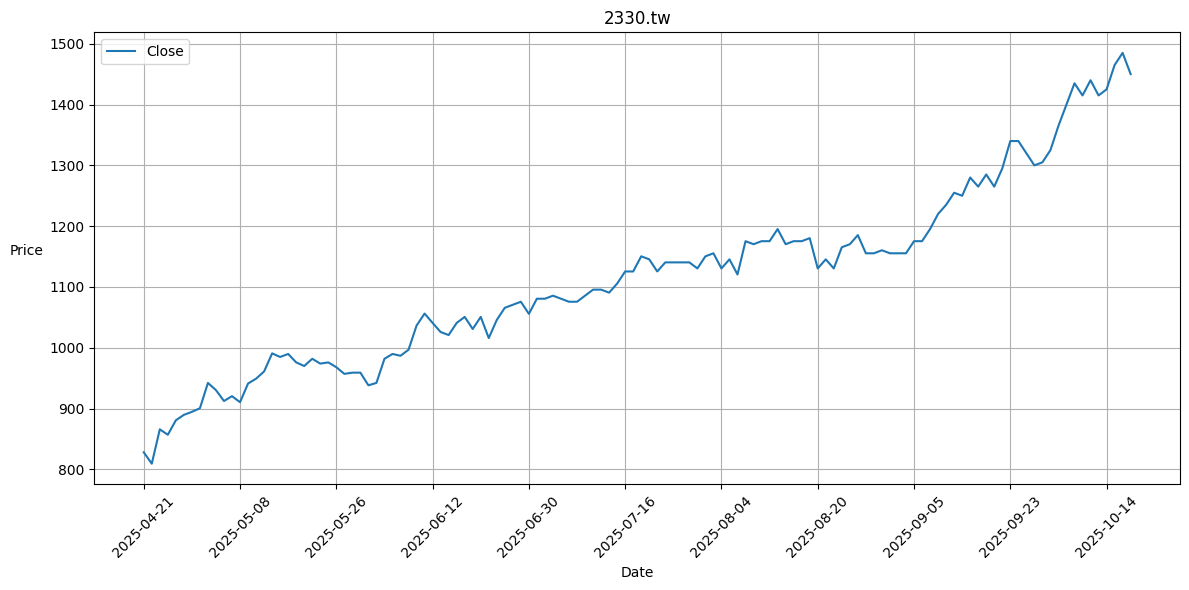

In [14]:
# 畫布尺寸大小設定
plt.figure(figsize=(12, 6))

# 設定要繪製的資料欄位
plt.plot(new_df['Close'], label='Close')

# 設定 x 軸的時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,
           date[::len(date)//num], rotation = 45)

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price', rotation=0, ha='right')  # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True) # 在圖上顯示網格
plt.tight_layout()

# 顯示圖表
plt.show()

### 1️⃣4️⃣ 加入成交量

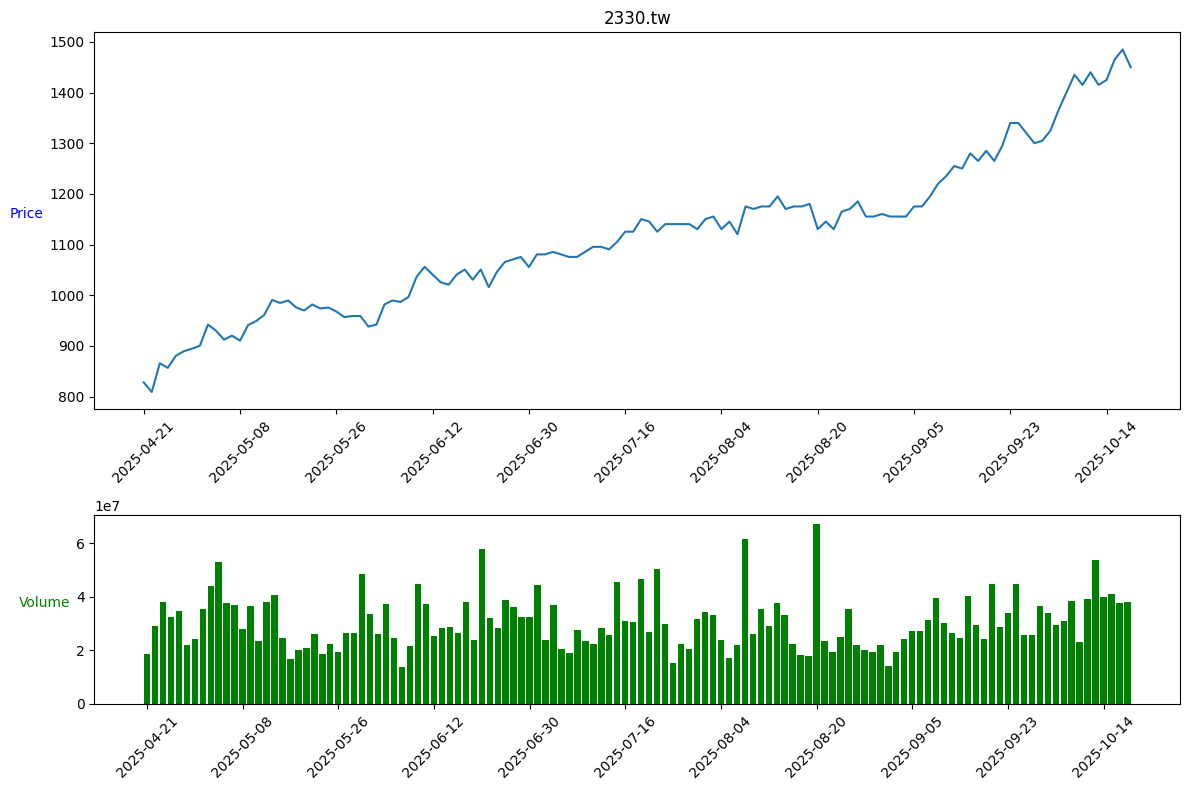

In [15]:
# 創建兩張子圖
fig, (ax1, ax2) = plt.subplots(2, 1,
                figsize=(12, 8),
                gridspec_kw={'height_ratios': [2, 1]})

# 設定 x 軸時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num], rotation=45)

# 繪製交易量
ax2.bar(new_df.index,  new_df['Volume'].values.reshape(len(new_df)), color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')
ax2.set_xticks([]) # 不顯示日期標籤
# 若要顯示圖表標籤可以使用以下程式碼
ax2.set_xticks(date[::len(date)//num].index)
ax2.set_xticklabels(date[::len(date)//num], rotation=45)

# 讓子圖填充、對齊
plt.tight_layout()

# 顯示圖表
plt.show()


### 1️⃣5️⃣ 加入技術指標

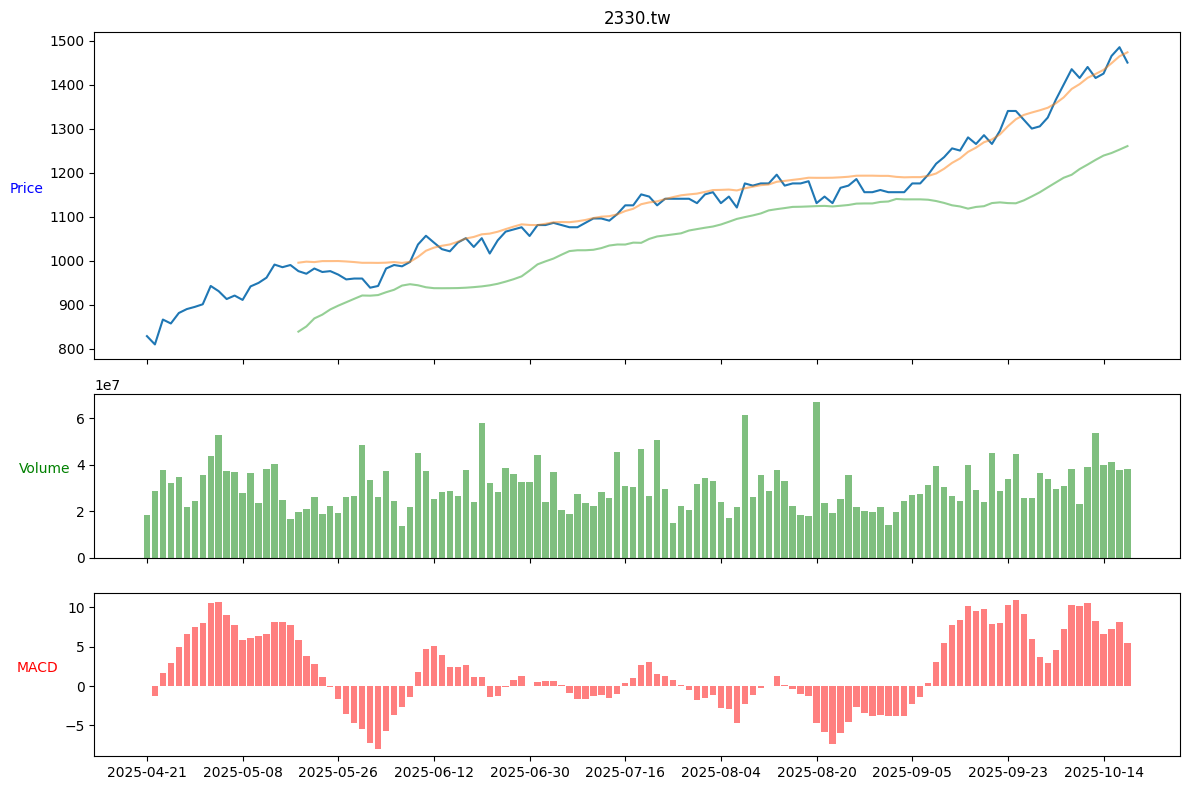

In [16]:
# 創建三個子圖
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,
                    figsize=(12, 8),
                    gridspec_kw={'height_ratios': [2, 1, 1]},
                    sharex=True)

# 設定 x 軸時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
# 加入布林通道
ax1.plot(new_df['Upper_Band'], alpha=0.5) # alpha 設定透明度
ax1.plot(new_df['Lower_Band'], alpha=0.5)
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num])

# 繪製交易量
ax2.bar(new_df.index, new_df['Volume'].values.reshape(len(new_df)), alpha=0.5, color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')

# 繪製技術指標
ax3.bar(new_df.index, new_df['MACD_Histogram'].values.reshape(len(new_df)), alpha=0.5, color='red')
ax3.set_ylabel('MACD', color='red', rotation=0, ha='right')

# 調整子圖間的距離
plt.tight_layout()

# 顯示圖表
plt.show()

### 繪製 K 線圖：mplfinance

### 1️⃣6️⃣ 匯入技術分析繪圖套件

In [17]:
!pip install mplfinance -U
import mplfinance as mpf

### 1️⃣7️⃣ 選擇資料時間

In [18]:
kplot_df = new_df.set_index('Date')
#kplot_df = kplot_df['2024-02-01':'2024-07-29']
kplot_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_8,MA_13,EMA_12,EMA_26,MACD_Line,Signal_Line,MACD_Histogram,RSI,SMA_20,Rolling_Std_20,Upper_Band,Lower_Band,OBV
Date,,,,,,,,,,,,,,,,,,,,
2025-10-13 00:00:00+08:00,1390.0,1420.0,1390.0,1415.0,53850992,0.0,0.0,1387.50,1361.153846,1370.679024,1311.738816,58.940207,50.610131,8.330076,69.305693,1326.501990,65.109998,1424.166987,1228.836992,918434351
2025-10-14 00:00:00+08:00,1455.0,1460.0,1420.0,1425.0,39889256,0.0,0.0,1402.50,1371.153846,1379.036097,1320.128534,58.907563,52.269618,6.637946,70.378682,1335.999005,64.922311,1433.382472,1238.615538,958323607
2025-10-15 00:00:00+08:00,1435.0,1465.0,1425.0,1465.0,41056405,0.0,0.0,1420.00,1380.769231,1392.261313,1330.859753,61.401559,54.096006,7.305553,74.255431,1346.500000,68.038302,1448.557453,1244.442547,999380012
2025-10-16 00:00:00+08:00,1465.0,1495.0,1465.0,1485.0,37737678,0.0,0.0,1435.00,1391.923077,1406.528803,1342.277549,64.251254,56.127056,8.124198,75.950269,1358.250000,70.734399,1464.351599,1252.148401,1037117690
2025-10-17 00:00:00+08:00,1455.0,1465.0,1450.0,1450.0,38077331,0.0,0.0,1441.25,1401.923077,1413.216680,1350.256990,62.959689,57.493582,5.466107,67.567231,1366.750000,71.049927,1473.324890,1260.175110,999040359


### 1️⃣8️⃣ 用 mplfinance 繪製 K 線圖

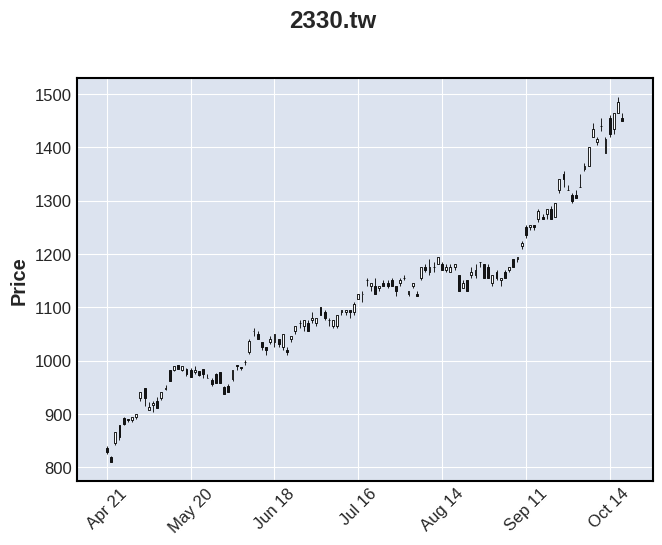

In [19]:
mpf.plot(kplot_df, type='candle', title=f'{stock_id}')

### 1️⃣9️⃣ 加入繪圖設定

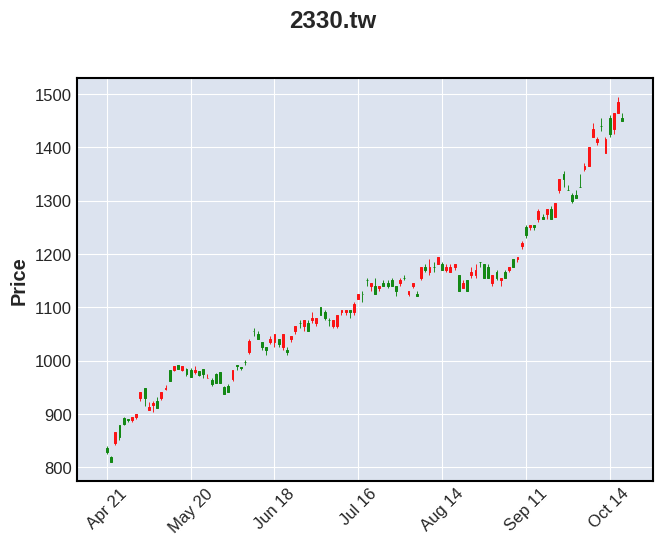

In [20]:
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default',
                marketcolors=my_color)
# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', style=my_style, title=f'{stock_id}')

### 2️⃣0️⃣ 加入子圖

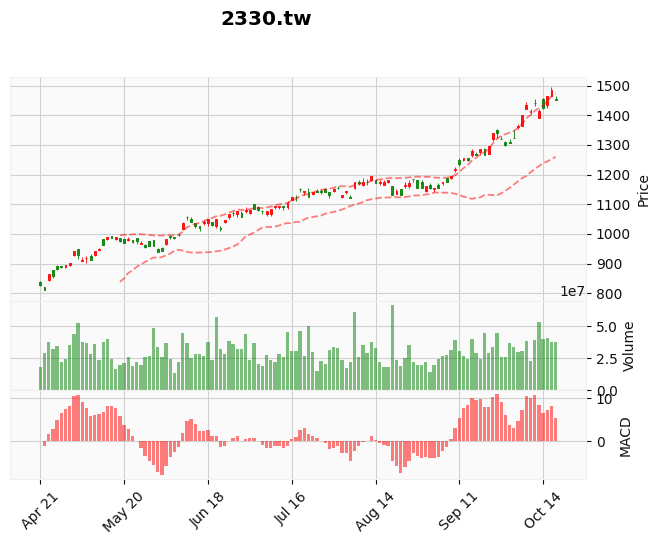

In [21]:
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='yahoo',
                marketcolors=my_color)

# 交易量和技術指標子圖
ap = [
    # 上軌線
    mpf.make_addplot(kplot_df['Upper_Band'], color='red',
                      alpha=0.5, linestyle='--'),
    # 下軌線
    mpf.make_addplot(kplot_df['Lower_Band'], color='red',
                     alpha=0.5, linestyle='--'),
    # 成交量
    mpf.make_addplot(kplot_df['Volume'], panel=1, type='bar',
                     color='g', alpha=0.5, ylabel='Volume'),
    # MACD
    mpf.make_addplot(kplot_df['MACD_Histogram'], panel=2, type='bar',
                     color='r', alpha=0.5, ylabel='MACD')
]

# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', addplot=ap,
          style=my_style, title=f'{stock_id}')

## 4-3 plotly 互動式圖表

### 2️⃣1️⃣ 檢視資料

In [22]:
bk_df = new_df
bk_df.index = bk_df["Date"].dt.strftime('%Y-%m-%d')
bk_df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_8,MA_13,...,EMA_26,MACD_Line,Signal_Line,MACD_Histogram,RSI,SMA_20,Rolling_Std_20,Upper_Band,Lower_Band,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2025-10-13,2025-10-13 00:00:00+08:00,1390.0,1420.0,1390.0,1415.0,53850992,0.0,0.0,1387.50,1361.153846,...,1311.738816,58.940207,50.610131,8.330076,69.305693,1326.501990,65.109998,1424.166987,1228.836992,918434351
2025-10-14,2025-10-14 00:00:00+08:00,1455.0,1460.0,1420.0,1425.0,39889256,0.0,0.0,1402.50,1371.153846,...,1320.128534,58.907563,52.269618,6.637946,70.378682,1335.999005,64.922311,1433.382472,1238.615538,958323607
2025-10-15,2025-10-15 00:00:00+08:00,1435.0,1465.0,1425.0,1465.0,41056405,0.0,0.0,1420.00,1380.769231,...,1330.859753,61.401559,54.096006,7.305553,74.255431,1346.500000,68.038302,1448.557453,1244.442547,999380012
2025-10-16,2025-10-16 00:00:00+08:00,1465.0,1495.0,1465.0,1485.0,37737678,0.0,0.0,1435.00,1391.923077,...,1342.277549,64.251254,56.127056,8.124198,75.950269,1358.250000,70.734399,1464.351599,1252.148401,1037117690
2025-10-17,2025-10-17 00:00:00+08:00,1455.0,1465.0,1450.0,1450.0,38077331,0.0,0.0,1441.25,1401.923077,...,1350.256990,62.959689,57.493582,5.466107,67.567231,1366.750000,71.049927,1473.324890,1260.175110,999040359


### 2️⃣2️⃣ 匯入 plotly 套件

In [23]:
import plotly.graph_objects as go

### 2️⃣3️⃣ 繪製互動式 K 線圖

In [24]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])

# 調整寬高
fig.update_layout(
    height=800,
    width=1200
)

# 顯示圖表
fig.show()

### 2️⃣4️⃣ 移除非交易日空值
解決繪圖不連續問題

In [25]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])

# 調整寬高
fig.update_layout(
    height=800,
    width=1200
)

# 移除非交易日空值
# 生成該日期範圍內的所有日期
all_dates = pd.date_range(start=bk_df.index.min(),
              end=bk_df.index.max())
# 找出不在資料中的日期
breaks = all_dates[~all_dates.isin(bk_df.index)]
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

# 顯示圖表
fig.show()

/tmp/ipython-input-1835360458.py:21: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣5️⃣ 加入懸停十字軸

In [26]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])


# 圖表更新-加入懸停十字軸
fig.update_xaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")
fig.update_yaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")
fig.update_layout(
    height=800,
    width=1200
)


# 移除非交易日空值
all_dates = pd.date_range(start=bk_df.index.min(), end=bk_df.index.max()) # 生成該日期範圍內的所有日期
breaks = all_dates[~all_dates.isin(bk_df.index)] # 找出不在資料中的日期
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

fig.show()

/tmp/ipython-input-3746432464.py:24: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣6️⃣ 加入技術指標

In [27]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red', decreasing_line_color='green',
            name = "K 線")])


# 布林通道
fig.add_trace(go.Scatter(
    x=bk_df.index, y=bk_df['Upper_Band'],mode='lines',
    line={'color': 'green','dash': 'dash'},name = "上軌線"))
fig.add_trace(go.Scatter(
    x=bk_df.index, y=bk_df['Lower_Band'], mode='lines',
    line={'color': 'green', 'dash': 'dash'},name = "下軌線"))

# 交易量
fig.add_trace(go.Bar(
    x=bk_df.index, y=bk_df['Volume'], marker={'color': 'green'},
      yaxis='y2', name = "交易量"))

# MACD
fig.add_trace(go.Bar(
    x=bk_df.index, y=bk_df['MACD_Histogram'], marker={'color': 'red'},
      yaxis='y3', name = "MACD"))

# 加入懸停十字軸
fig.update_xaxes(showspikes=True, spikecolor="gray",
                 spikemode="toaxis")
fig.update_yaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")

# 更新畫布大小並增加範圍選擇
fig.update_layout(
    height=800,
    yaxis={'domain': [0.35, 1]},
    yaxis2={'domain': [0.15, 0.3]},
    yaxis3={'domain': [0, 0.15]},
    title=f"{stock_id}",
    xaxis={
        # 範圍選擇格
        'rangeselector': {
            'buttons': [
                {'count': 1, 'label': '1M',
                  'step': 'month', 'stepmode': 'backward'},
                {'count': 6, 'label': '6M',
                  'step': 'month', 'stepmode': 'backward'},
                {'count': 1, 'label': '1Y',
                  'step': 'year', 'stepmode': 'backward'},
                {'step': 'all'}
            ]
        },
        # 範圍滑動條
        'rangeslider': {
            'visible': True,
            # 滑動條的高度 (設置 0.01 就會變單純的 bar)
            'thickness': 0.01,
            'bgcolor': "#E4E4E4"  # 背景色
        },
        'type': 'date'
    }
)


# 移除非交易日空值
all_dates = pd.date_range(start=bk_df.index.min(), end=bk_df.index.max()) # 生成該日期範圍內的所有日期
breaks = all_dates[~all_dates.isin(bk_df.index)] # 找出不在資料中的日期
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

fig.show()

/tmp/ipython-input-3180122684.py:69: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣7️⃣ 寫成函式

In [28]:
# 下載資料並讓 AI 計算指標
def download_stock_data(stock_id, start=None, end=None, indicator='MACD'):
    stock_id = f"{stock_id}.tw"
    if not end:
        end = dt.date.today()
    if not start:
        start = end - dt.timedelta(days=365)
    # 從 yf 下載資料
    #df = yf.download(stock_id, start=start, end=end).reset_index()
    df = yf.Ticker(stock_id).history(start=start, end=end)

    # AI 計算技術指標
    code_str = ai_helper(df, f"計算{indicator}")
    code_str=code_str.replace('```','')
    code_str=code_str.replace('python','')
    print(code_str)

    # 將 exec 生成的 calculate 設為局部變數
    local_vars = {}
    exec(code_str, globals(), local_vars)
    calculate = local_vars['calculate']

    df = calculate(df)

    # 資料處理
    bk_df = df.reset_index()
    bk_df.index = bk_df["Date"].dt.strftime('%Y-%m-%d')

    return bk_df

# 繪製圖表函式
def create_stock_figure(stock_id, bk_df):

    # 創建 K 線圖
    fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
                        open=bk_df['Open'],
                        high=bk_df['High'],
                        low=bk_df['Low'],
                        close=bk_df['Close'],
                        increasing_line_color='red',
                        decreasing_line_color='green',
                        name = "K 線")])

    # 交易量
    fig.add_trace(go.Bar(x=bk_df.index, y=bk_df['Volume'],
                         marker={'color': 'green'}, yaxis='y2',
                           name = "交易量"))

    # 找出需要繪製的欄位
    columns = bk_df.columns
    exclude_columns = ['index','Date', 'Open', 'High',
                        'Low', 'Close', 'Adj Close', 'Volume']
    remain_columns = [col for col in columns if
                       col not in exclude_columns]
    min_close = bk_df['Close'].min() - bk_df['Close'].std()
    max_close = bk_df['Close'].max() + bk_df['Close'].std()
    # 繪製技術指標
    for i in remain_columns:
      if min_close <= bk_df[i].mean() <= max_close:
        fig.add_trace(go.Scatter(x=bk_df.index, y=bk_df[i],
                                  mode='lines', name=i))
      else:
        fig.add_trace(go.Scatter(x=bk_df.index, y=bk_df[i],
                                  mode='lines', yaxis='y3', name=i))

    # 加入懸停十字軸
    fig.update_xaxes(showspikes=True, spikecolor="gray",
                    spikemode="toaxis")
    fig.update_yaxes(showspikes=True, spikecolor="gray",
                    spikemode="across")
    # 更新畫布大小並增加範圍選擇
    fig.update_layout(
        height=800,
        width=1200,
        yaxis={'domain': [0.35, 1]},
        yaxis2={'domain': [0.15, 0.3]},
        # 若要重疊 y1 和 y3, 可以改成
        # yaxis3=dict(overlaying='y', side='right')
        yaxis3={'domain': [0, 0.15]},
        title=f"{stock_id}",
        xaxis={
            # 範圍選擇格
            'rangeselector': {
                'buttons': [
                    {'count': 1, 'label': '1M',
                      'step': 'month', 'stepmode': 'backward'},
                    {'count': 6, 'label': '6M',
                      'step': 'month', 'stepmode': 'backward'},
                    {'count': 1, 'label': '1Y',
                      'step': 'year', 'stepmode': 'backward'},
                    {'step': 'all'}
                ]
            },
            # 範圍滑動條
            'rangeslider': {
                'visible': True,
                'thickness': 0.01,  # 滑動條的高度
                'bgcolor': "#E4E4E4"  # 背景色
            },
            'type': 'date'
        }
    )

    # 移除非交易日空值
    # 生成該日期範圍內的所有日期
    all_dates = pd.date_range(start=bk_df.index.min(),
                               end=bk_df.index.max())
    # 找出不在資料中的日期
    breaks = all_dates[~all_dates.isin(bk_df.index)]
    dt_breaks = breaks.tolist() # 轉換成列表格式
    fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

    return fig

# 主函式
def plotly_stock(stock_id, start=None, end=None, indicator='MACD'):

    df = download_stock_data(stock_id, start, end, indicator)
    fig = create_stock_figure(stock_id,df)
    fig.show()

### 2️⃣8️⃣ 執行函式

In [30]:
plotly_stock("2454", start='2022-01-01', end= None, indicator='布林通道 及 MACD')


import pandas as pd

def calculate(df):
    """
    Calculates Bollinger Bands and MACD and adds them to the dataframe.

    Parameters:
    df (pd.DataFrame): The input dataframe with 'Close' price.

    Returns:
    pd.DataFrame: The dataframe with Bollinger Bands and MACD indicators added.
    """

    # --- Bollinger Bands Calculation ---
    # 20-period Simple Moving Average (SMA)
    df['BB_Middle_Band'] = df['Close'].rolling(window=20).mean()
    # 20-period Standard Deviation
    df['BB_StdDev'] = df['Close'].rolling(window=20).std()
    # Upper Band (Middle Band + 2 * StdDev)
    df['BB_Upper_Band'] = df['BB_Middle_Band'] + (df['BB_StdDev'] * 2)
    # Lower Band (Middle Band - 2 * StdDev)
    df['BB_Lower_Band'] = df['BB_Middle_Band'] - (df['BB_StdDev'] * 2)

    # --- MACD Calculation ---
    # 12-period Exponential Moving Average (EMA)
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    # 26-period Exponential Moving Average (EMA)
    df['EMA_26'] = df['Clo

/tmp/ipython-input-1935600896.py:109: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.

